<a href="https://colab.research.google.com/github/rmvjh27/hackbio-stage3/blob/main/Stage3_Single_Cell_Analysis_With_Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scRNA-seq Data Analysis with Trajectory Inference

## 0. Install the required libraries

In [ ]:
!pip install scanpy
!pip install anndata
!pip install igraph
!pip install decoupler
!pip install fa2-modified

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 41.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19876 sha256=39d3c28e5cd4bc7e676f74101d808ecbfdffd8004b0a5170f6b2af39e5c3e6b6
  Stored in directory

In [ ]:
# Import core tools
import scanpy as sc
import anndata as ad
import numpy as np

## 1. Import the data

In [ ]:
# make a new directory
!mkdir -p GSE166766

# download the dataset
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar -O /content/GSE166766/GSE166766_RAW.tar

# extract the .tar file
!tar -xvf /content/GSE166766/GSE166766_RAW.tar -C /content/GSE166766

--2025-12-13 03:34:38--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 838123520 (799M) [application/x-tar]
Saving to: ‘/content/GSE166766/GSE166766_RAW.tar’

/content/GSE166766/ 100%[===================>] 799.30M  57.8MB/s    in 19s     

2025-12-13 03:34:57 (42.6 MB/s) - ‘/content/GSE166766/GSE166766_RAW.tar’ saved [838123520/838123520]

GSM5082289_mock_barcodes.tsv.gz
GSM5082289_mock_features.tsv.gz
GSM5082289_mock_matrix.mtx.gz
GSM5082290_1dpi_barcodes.tsv.gz
GSM5082290_1dpi_features.tsv.gz
GSM5082290_1dpi_matrix.mtx.gz
GSM5082291_2dpi_barcodes.tsv.gz
GSM5082291_2dpi_features.tsv.gz
GSM5082291_2dpi_matrix.mtx.gz
GSM5082292_3dpi_barcodes.tsv.gz
GSM5082292_3dpi_features.tsv.gz
GSM5082292_3dpi_matrix

In [ ]:
# make new working directory
import shutil
!mkdir working_dir
!mkdir /content/working_dir/mock /content/working_dir/1dpi /content/working_dir/2dpi /content/working_dir/3dpi

groups = ['mock', '1dpi', '2dpi', '3dpi']
filenames = ['GSM5082289_mock', 'GSM5082290_1dpi',
             'GSM5082291_2dpi', 'GSM5082292_3dpi']

# copy barcodes, features, and matrix files from the GSE151309 folder to corresponding folders
for i in range(len(groups)):
    shutil.copy(f'/content/GSE166766/{filenames[i]}_barcodes.tsv.gz', f'/content/working_dir/{groups[i]}/barcodes.tsv.gz')
    shutil.copy(f'/content/GSE166766/{filenames[i]}_features.tsv.gz', f'/content/working_dir/{groups[i]}/features.tsv.gz')
    shutil.copy(f'/content/GSE166766/{filenames[i]}_matrix.mtx.gz', f'/content/working_dir/{groups[i]}/matrix.mtx.gz')

# delete unused files
!rm -rf /content/GSE166766

In [ ]:
# load the data into AnnData objects
mock_adata = sc.read_10x_mtx('/content/working_dir/mock/')
dpi1_adata = sc.read_10x_mtx('/content/working_dir/1dpi/')
dpi2_adata = sc.read_10x_mtx('/content/working_dir/2dpi/')
dpi3_adata = sc.read_10x_mtx('/content/working_dir/3dpi/')

# keep only unique gene names
mock_adata.var_names_make_unique()
dpi1_adata.var_names_make_unique()
dpi2_adata.var_names_make_unique()
dpi3_adata.var_names_make_unique()

## 2. Quality Control and Normalization

In [ ]:
# check whether each AnnData object has the same number of observations and variables
print(mock_adata)
print(dpi1_adata)
print(dpi2_adata)
print(dpi3_adata)

AnnData object with n_obs × n_vars = 22609 × 33539
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 11834 × 33539
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 14695 × 33539
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 28530 × 33539
    var: 'gene_ids', 'feature_types'


In [ ]:
# function for removing genes expressed in less than 3 cells and cells with less than 200 genes
def filter_cells_genes(adata):
  # remove genes expressed in less than 3 cells, as these genes likely show no significance for the study
  sc.pp.filter_genes(adata, min_cells=3)
  # remove cells expressing less than 200 genes, as these likely indicate empty droplets
  sc.pp.filter_cells(adata, min_genes=200)
  # return the annotated data object
  return adata

In [ ]:
# filter cells and genes with the defined function
filter_cells_genes(mock_adata)
filter_cells_genes(dpi1_adata)
filter_cells_genes(dpi2_adata)
filter_cells_genes(dpi3_adata)

AnnData object with n_obs × n_vars = 28523 × 22251
    obs: 'condition', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [ ]:
# check dimensions after filtering
print(mock_adata.shape)
print(dpi1_adata.shape)
print(dpi2_adata.shape)
print(dpi3_adata.shape)

(22608, 21691)
(11829, 21983)
(14690, 22170)
(28523, 22251)


In [ ]:
# index for mitochondrial reads
mock_adata.var['MT'] = mock_adata.var_names.str.startswith('MT-')
dpi1_adata.var['MT'] = dpi1_adata.var_names.str.startswith('MT-')
dpi2_adata.var['MT'] = dpi2_adata.var_names.str.startswith('MT-')
dpi3_adata.var['MT'] = dpi3_adata.var_names.str.startswith('MT-')

# index for ribosomal transcripts
mock_adata.var['ribo'] = mock_adata.var_names.str.startswith(("RPS","RPL"))
dpi1_adata.var['ribo'] = dpi1_adata.var_names.str.startswith(("RPS","RPL"))
dpi2_adata.var['ribo'] = dpi2_adata.var_names.str.startswith(("RPS","RPL"))
dpi3_adata.var['ribo'] = dpi3_adata.var_names.str.startswith(("RPS","RPL"))

# index for hemoglobin genes
mock_adata.var['HB'] = mock_adata.var_names.str.startswith("^HB[^(P)]")
dpi1_adata.var['HB'] = dpi1_adata.var_names.str.startswith("^HB[^(P)]")
dpi2_adata.var['HB'] = dpi2_adata.var_names.str.startswith("^HB[^(P)]")
dpi3_adata.var['HB'] = dpi3_adata.var_names.str.startswith("^HB[^(P)]")

In [ ]:
# which genes are mitochondrial?
mock_adata.var['MT'].loc[mock_adata.var['MT'] == True]

MT-ND1     True
MT-ND2     True
MT-CO1     True
MT-CO2     True
MT-ATP8    True
MT-ATP6    True
MT-CO3     True
MT-ND3     True
MT-ND4L    True
MT-ND4     True
MT-ND5     True
MT-ND6     True
MT-CYB     True
Name: MT, dtype: bool

In [ ]:
# which genes are ribosomal?
mock_adata.var['ribo'].loc[mock_adata.var['ribo'] == True]

RPL22       True
RPL11       True
RPS6KA1     True
RPS8        True
RPL5        True
            ... 
RPL28       True
RPS5        True
RPS4Y1      True
RPL3        True
RPS19BP1    True
Name: ribo, Length: 100, dtype: bool

In [ ]:
# hemoglobin genes
mock_adata.var['HB'].loc[mock_adata.var['HB'] == True]

Series([], Name: HB, dtype: bool)

In [ ]:
# function for calculating QC metrics and visualizing cells based on percentage mitochondrial and ribosomal reads
def calc_qc_and_plot(adata):
  # calculate QC metrics
  sc.pp.calculate_qc_metrics(adata,qc_vars=['MT', 'ribo', 'HB'],inplace=True)
  # create violin plot visualizing pct_counts_MT and pct_counts_ribo
  sc.pl.violin(adata,["pct_counts_MT", "pct_counts_ribo"],jitter=0.4)

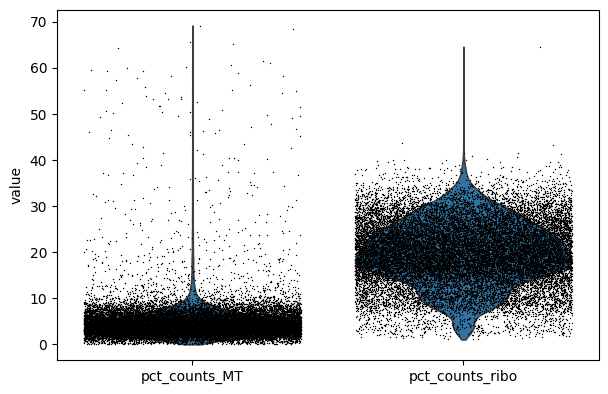

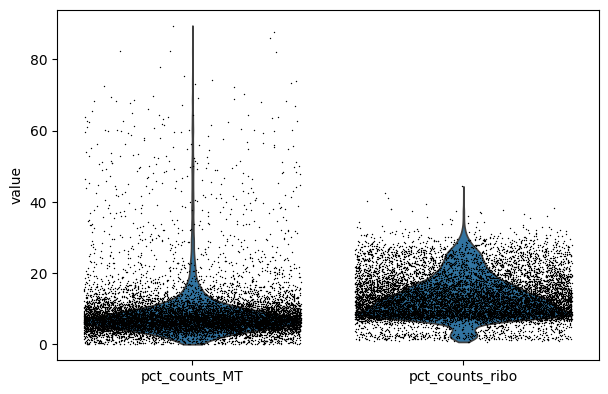

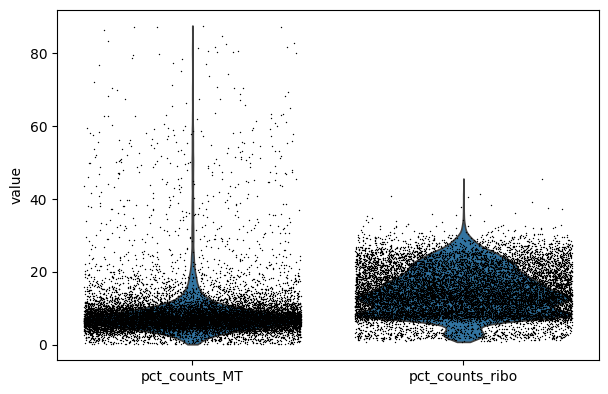

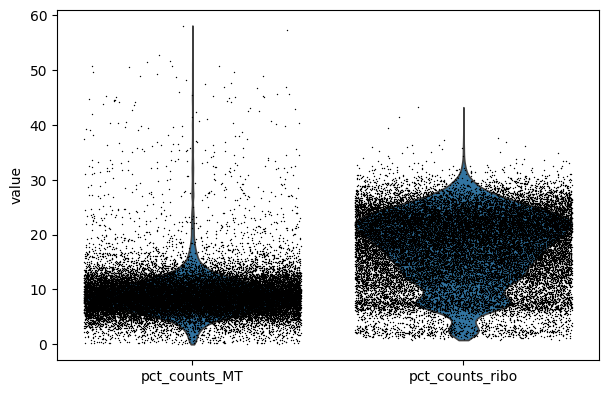

In [ ]:
# calculate QC metrics and visualize cells based on percentage mitochondrial and ribosomal reads
calc_qc_and_plot(mock_adata)
calc_qc_and_plot(dpi1_adata)
calc_qc_and_plot(dpi2_adata)
calc_qc_and_plot(dpi3_adata)

In [ ]:
# remove cells with mitochondrial genes above 10%, as these likely indicate dying cells
mock_adata = mock_adata[mock_adata.obs['pct_counts_MT'] < 10, :]
dpi1_adata = dpi1_adata[dpi1_adata.obs['pct_counts_MT'] < 10, :]
dpi2_adata = dpi2_adata[dpi2_adata.obs['pct_counts_MT'] < 10, :]
dpi3_adata = dpi3_adata[dpi3_adata.obs['pct_counts_MT'] < 10, :]

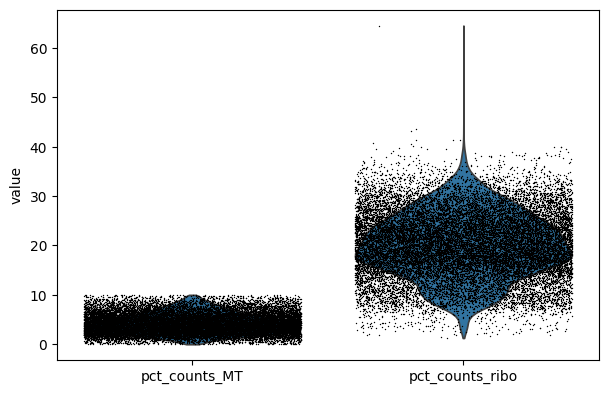

In [ ]:
# visualize spread of % mitochondrial reads after filtering
sc.pl.violin(mock_adata,["pct_counts_MT", "pct_counts_ribo"],jitter=0.4)

In [ ]:
# Save a copy of the raw counts as a new layer
mock_adata.layers["counts"] = mock_adata.X.copy()
dpi1_adata.layers["counts"] = dpi1_adata.X.copy()
dpi2_adata.layers["counts"] = dpi2_adata.X.copy()
dpi3_adata.layers["counts"] = dpi3_adata.X.copy()

/tmp/ipython-input-1291024713.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  mock_adata.layers["counts"] = mock_adata.X.copy()
/tmp/ipython-input-1291024713.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  dpi1_adata.layers["counts"] = dpi1_adata.X.copy()
/tmp/ipython-input-1291024713.py:4: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  dpi2_adata.layers["counts"] = dpi2_adata.X.copy()
/tmp/ipython-input-1291024713.py:5: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  dpi3_adata.layers["counts"] = dpi3_adata.X.copy()


In [ ]:
# function for data normalization, log-transformation, and feature selection
def normalize_and_transform(adata):
  # normalize towards the median
  sc.pp.normalize_total(adata)
  # log-transformation
  sc.pp.log1p(adata)
  # select 1000 most variable genes
  sc.pp.highly_variable_genes(adata, n_top_genes=1000)
  # plot data after and before normalization, with highly variable genes being indicated
  sc.pl.highly_variable_genes(adata)

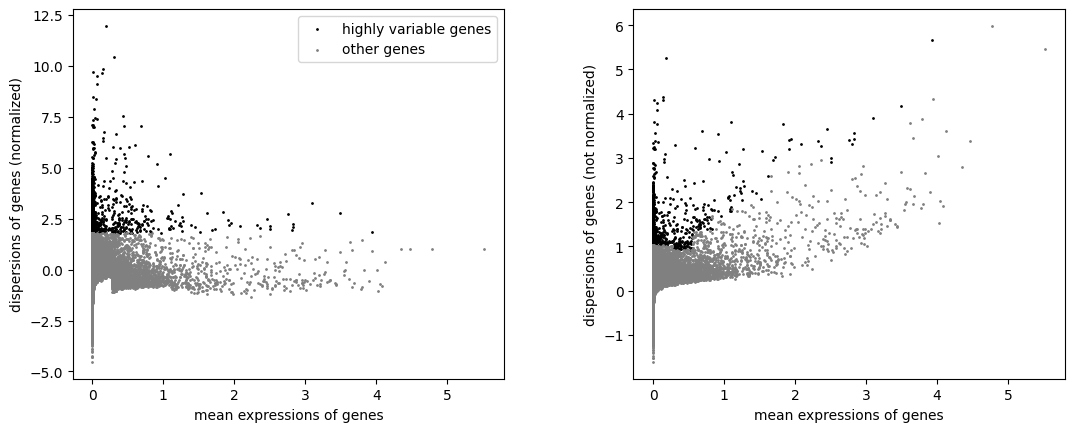

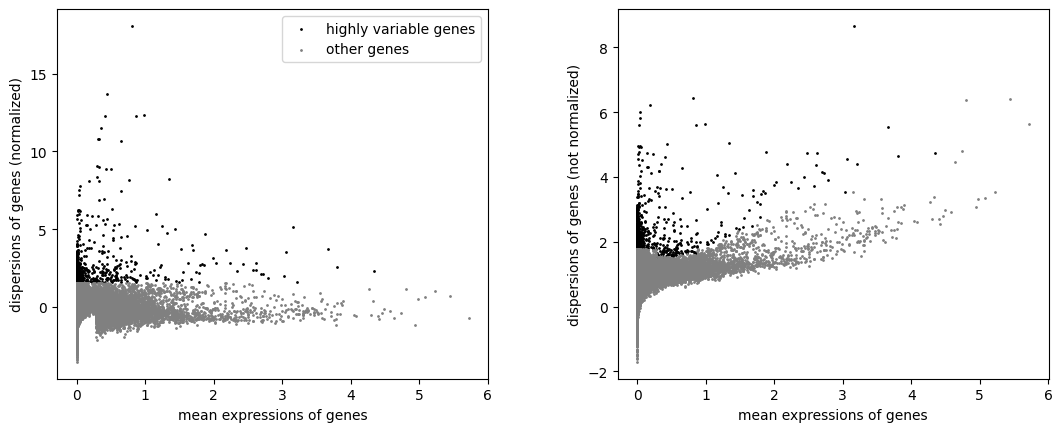

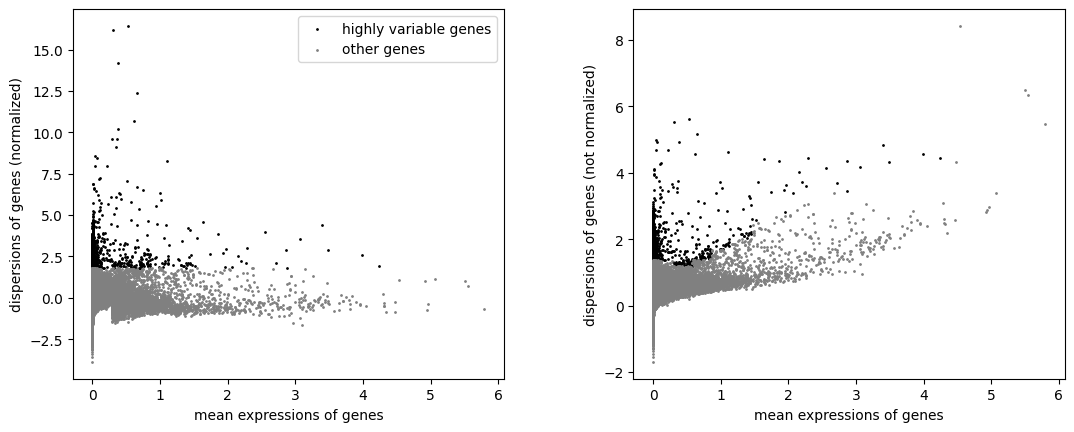

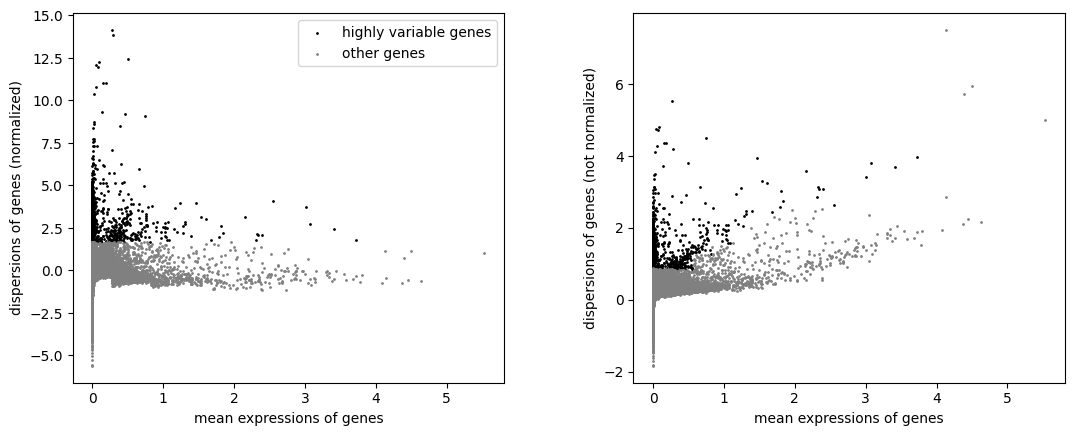

In [ ]:
# perform normalization
normalize_and_transform(mock_adata)
normalize_and_transform(dpi1_adata)
normalize_and_transform(dpi2_adata)
normalize_and_transform(dpi3_adata)

## 3. Dimensionality Reduction and Clustering

In [ ]:
# function for dimensionality reduction and clustering (PCA, nearest neighbors, UMAP clustering, Leiden clustering)
def reduce_and_cluster(adata):
  # perform PCA and display clustering of cells based on principal components
  sc.tl.pca(adata)
  sc.pl.pca(adata, color = 'pct_counts_MT', cmap='cool')

  # compute nearest neighbors and perform UMAP clustering
  sc.pp.neighbors(adata)
  sc.tl.umap(adata)

  # Leiden clustering and visualization of Leiden clusters
  sc.tl.leiden(adata, flavor='igraph', n_iterations=2, resolution=0.15)
  sc.pl.umap(adata, color=['leiden'], size=8)

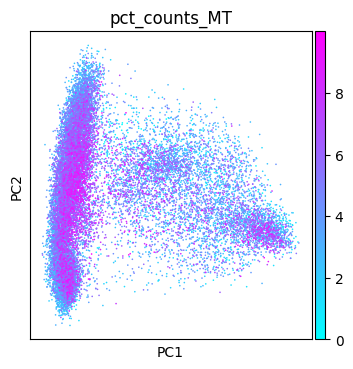

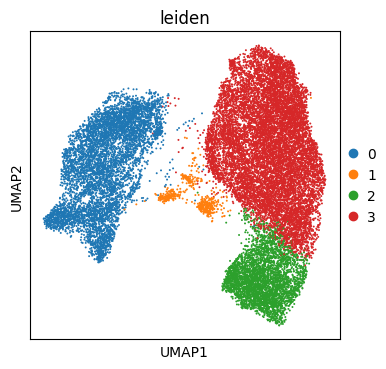

In [ ]:
# perform dimensionality reduction and clustering on each dataset
# mock
reduce_and_cluster(mock_adata)

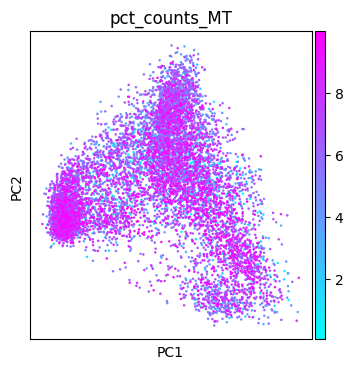

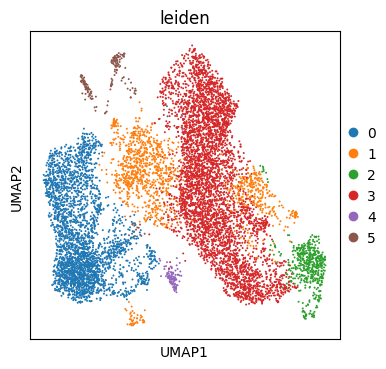

In [ ]:
# 1dpi
reduce_and_cluster(dpi1_adata)

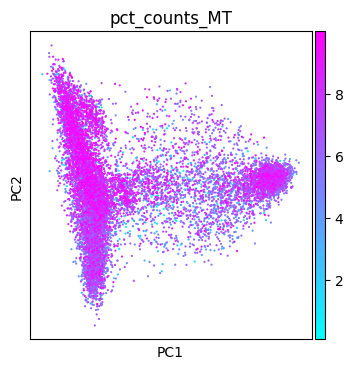

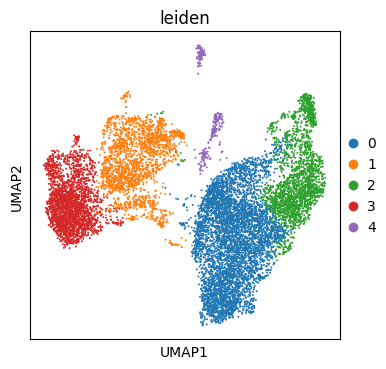

In [ ]:
# 2dpi
reduce_and_cluster(dpi2_adata)

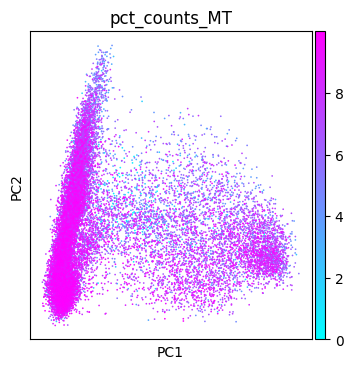

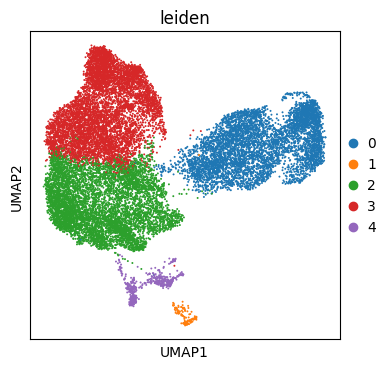

In [ ]:
# 3dpi
reduce_and_cluster(dpi3_adata)

## 4. Cell Type Annotation

In [ ]:
# import the decoupler library
import decoupler as dc

# query Omnipath and fetch PanglaoDB as repository of marker genes
markers = dc.op.resource(name='PanglaoDB', organism='human', license='academic', verbose=True)

# preview list of markers
markers.head()

Progress: 6.01MB [00:00, 15.1MB/s]


genesymbol  canonical_marker      cell_type germ_layer  human  \
                                                                  
0       A1CF             False    Hepatocytes   Endoderm   True   
1     A2APA5             False     Germ cells   Mesoderm  False   
2        A2M              True  Bergmann glia   Ectoderm   True   
3     A3FIN4             False     Mast cells   Mesoderm  False   
4     A4GALT              True     Mast cells   Mesoderm   True   

   human_sensitivity  human_specificity  mouse  mouse_sensitivity  \
                                                                    
0           0.189189           0.004437   True           0.175000   
1           0.000000           0.000000   True           0.432927   
2           0.000000           0.062343   True           0.333333   
3           0.000000           0.000000   True           0.184211   
4           0.000000           0.014133   True           0.000000   

   mouse_specificity  ncbi_tax_id          organ  ubiquitiousness  
                                                                   
0           0.000257         9606          Liver            0.002  
1           0.000000        10090   Reproductive            0.004  
2           0.001604         9606          Brain            0.012  
3           0.000708        10090  Immune system            0.001  
4           0.003023         9606  Immune system            0.005

In [ ]:
# display all possible organs
markers['organ'].unique()

array(['Liver', 'Reproductive', 'Brain', 'Immune system', 'Zygote',
       'Kidney', 'Blood', 'Lungs', 'Bone', 'GI tract', nan, 'Vasculature',
       'Pancreas', 'Heart', 'Mammary gland', 'Olfactory system',
       'Connective tissue', 'Epithelium', 'Skeletal muscle', 'Skin',
       'Embryo', 'Smooth muscle', 'Eye', 'Adrenal glands', 'Thyroid',
       'Placenta', 'Thymus', 'Parathyroid glands', 'Oral cavity',
       'Urinary bladder'], dtype=object)

In [ ]:
# keep only markers that are specific to lungs
markers = markers[markers['organ'] == 'Lungs']

In [ ]:
# preview markers that are going to be used (which indicate lung cells)
markers.head()

genesymbol  canonical_marker                         cell_type germ_layer  \
                                                                                
18       ABCA3              True  Pulmonary alveolar type II cells   Endoderm   
31       ABCD3              True  Pulmonary alveolar type II cells   Endoderm   
172     ADGRF5              True  Pulmonary alveolar type II cells   Endoderm   
186       ADH7              True           Airway epithelial cells   Endoderm   
222       AGER              True   Pulmonary alveolar type I cells   Endoderm   

     human  human_sensitivity  human_specificity  mouse  mouse_sensitivity  \
                                                                             
18    True           0.692308           0.000944   True           0.007576   
31    True           0.000000           0.009437   True           0.340909   
172   True           0.538462           0.015728   True           0.590909   
186   True           0.000000           0.004386   True           0.000000   
222   True           0.000000           0.001253   True           1.000000   

     mouse_specificity  ncbi_tax_id  organ  ubiquitiousness  
                                                             
18            0.000518         9606  Lungs            0.001  
31            0.046722         9606  Lungs            0.041  
172           0.050023         9606  Lungs            0.047  
186           0.006288         9606  Lungs            0.006  
222           0.011382         9606  Lungs            0.011

In [ ]:
# keep only the canonical cell markers
markers = markers[markers['canonical_marker']]

# remove duplicate entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

# change the column names to 'source' and 'target'
markers = markers.rename(columns={'cell_type':'source', 'genesymbol':'target'})
markers = markers[['source', 'target']]

In [ ]:
# preview the list of marker genes
markers.head()

source  target
                                             
18   Pulmonary alveolar type II cells   ABCA3
31   Pulmonary alveolar type II cells   ABCD3
172  Pulmonary alveolar type II cells  ADGRF5
186           Airway epithelial cells    ADH7
222   Pulmonary alveolar type I cells    AGER

In [ ]:
# perform ULM scoring on gene expression data
dc.mt.ulm(data=mock_adata, net=markers, tmin=3, bsize=5000)

In [ ]:
dc.mt.ulm(data=dpi1_adata, net=markers, tmin=3, bsize=5000)

In [ ]:
dc.mt.ulm(data=dpi2_adata, net=markers, tmin=3, bsize=5000)

In [ ]:
dc.mt.ulm(data=dpi3_adata, net=markers, tmin=3, bsize=5000)

In [ ]:
# retrieve the scoring results and store it in the .obsm of each object
mock_score = dc.pp.get_obsm(mock_adata, key='score_ulm')
dpi1_score = dc.pp.get_obsm(dpi1_adata, key='score_ulm')
dpi2_score = dc.pp.get_obsm(dpi2_adata, key='score_ulm')
dpi3_score = dc.pp.get_obsm(dpi3_adata, key='score_ulm')

# preview the scoring results in mock
mock_adata.obsm['score_ulm'].head()

Airway epithelial cells  Airway goblet cells  \
AAACCCACAAGCCATT-1                 0.197889             4.373820   
AAACCCACAGACACAG-1                 0.922793            -0.198580   
AAACCCACAGAGGAAA-1                 1.430704             3.071839   
AAACCCACAGGACAGT-1                 1.062564             0.702658   
AAACCCACAGTTCTAG-1                -0.467742             6.296366   

                    Alveolar macrophages  Ciliated cells  Clara cells  \
AAACCCACAAGCCATT-1              0.197889        1.016067     5.571661   
AAACCCACAGACACAG-1              1.976168        0.833800     0.803403   
AAACCCACAGAGGAAA-1              2.051541       -0.484157     5.272171   
AAACCCACAGGACAGT-1             -0.428219        1.350553     1.068888   
AAACCCACAGTTCTAG-1             -0.467742       -0.405067     5.580231   

                    Ionocytes  Pulmonary alveolar type I cells  \
AAACCCACAAGCCATT-1  -0.949939                         0.928951   
AAACCCACAGACACAG-1  -0.837334                         3.403305   
AAACCCACAGAGGAAA-1  -0.069718                         1.759942   
AAACCCACAGGACAGT-1  -0.605651                        -0.470820   
AAACCCACAGTTCTAG-1   0.288934                         1.882888   

                    Pulmonary alveolar type II cells  
AAACCCACAAGCCATT-1                          1.435508  
AAACCCACAGACACAG-1                          1.375807  
AAACCCACAGAGGAAA-1                         -0.193027  
AAACCCACAGGACAGT-1                         -0.436047  
AAACCCACAGTTCTAG-1                          0.119431

In [ ]:
# rank marker genes based on scoring results
mock_adata_rank = dc.tl.rankby_group(mock_score, groupby='leiden', reference='rest', method='t-test_overestim_var')
dpi1_adata_rank = dc.tl.rankby_group(dpi1_score, groupby='leiden', reference='rest', method='t-test_overestim_var')
dpi2_adata_rank = dc.tl.rankby_group(dpi2_score, groupby='leiden', reference='rest', method='t-test_overestim_var')
dpi3_adata_rank = dc.tl.rankby_group(dpi3_score, groupby='leiden', reference='rest', method='t-test_overestim_var')

In [ ]:
# keep only ranking results with t-test values more than 0
mock_adata_rank = mock_adata_rank[mock_adata_rank["stat"] > 0]
dpi1_adata_rank = dpi1_adata_rank[dpi1_adata_rank["stat"] > 0]
dpi2_adata_rank = dpi2_adata_rank[dpi2_adata_rank["stat"] > 0]
dpi3_adata_rank = dpi3_adata_rank[dpi3_adata_rank["stat"] > 0]

In [ ]:
# preview the ranking results
mock_adata_rank.head()

group reference                              name       stat  meanchange  \
0     0      rest                    Ciliated cells  92.084485    2.346492   
3     0      rest                       Clara cells  30.204911    1.303276   
4     0      rest  Pulmonary alveolar type II cells  24.138569    0.325692   
5     0      rest               Airway goblet cells  15.657923    0.582784   
6     0      rest              Alveolar macrophages  14.504375    0.259743   

            pval           padj  
0   0.000000e+00   0.000000e+00  
3  1.388808e-192  2.777615e-192  
4  1.001457e-125  1.602332e-125  
5   1.145151e-54   1.526868e-54  
6   2.894081e-47   3.307521e-47

In [ ]:
# annotate clustering results with top-ranked cell types
mock_cell_types = mock_adata_rank.groupby('group')['name'].apply(lambda x: x.head(1))
dpi1_cell_types = dpi1_adata_rank.groupby('group')['name'].apply(lambda x: x.head(1))
dpi2_cell_types = dpi2_adata_rank.groupby('group')['name'].apply(lambda x: x.head(1))
dpi3_cell_types = dpi3_adata_rank.groupby('group')['name'].apply(lambda x: x.head(1))

/tmp/ipython-input-3119210151.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mock_cell_types = mock_adata_rank.groupby('group')['name'].apply(lambda x: x.head(1))
/tmp/ipython-input-3119210151.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dpi1_cell_types = dpi1_adata_rank.groupby('group')['name'].apply(lambda x: x.head(1))
/tmp/ipython-input-3119210151.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dpi2_c

In [ ]:
# display cell types for mock
mock_cell_types

group    
0      0                      Ciliated cells
1      25                          Ionocytes
3      16    Pulmonary alveolar type I cells
Name: name, dtype: category
Categories (8, object): ['Airway epithelial cells', 'Airway goblet cells', 'Alveolar macrophages',
                         'Ciliated cells', 'Clara cells', 'Ionocytes',
                         'Pulmonary alveolar type I cells', 'Pulmonary alveolar type II cells']

In [ ]:
# display cell types for 1dpi
dpi1_cell_types

group    
0      0                      Ciliated cells
1      40                        Clara cells
2      14    Pulmonary alveolar type I cells
3      16    Pulmonary alveolar type I cells
4      35                Airway goblet cells
5      26                          Ionocytes
Name: name, dtype: category
Categories (8, object): ['Airway epithelial cells', 'Airway goblet cells', 'Alveolar macrophages',
                         'Ciliated cells', 'Clara cells', 'Ionocytes',
                         'Pulmonary alveolar type I cells', 'Pulmonary alveolar type II cells']

In [ ]:
# display cell types for 2dpi
dpi2_cell_types

group    
0      0                         Clara cells
1      8                      Ciliated cells
2      21    Pulmonary alveolar type I cells
3      24                     Ciliated cells
4      33                          Ionocytes
Name: name, dtype: category
Categories (8, object): ['Airway epithelial cells', 'Airway goblet cells', 'Alveolar macrophages',
                         'Ciliated cells', 'Clara cells', 'Ionocytes',
                         'Pulmonary alveolar type I cells', 'Pulmonary alveolar type II cells']

In [ ]:
# display cell types for 3dpi
dpi3_cell_types

group    
0      0     Ciliated cells
1      13         Ionocytes
2      16       Clara cells
4      34         Ionocytes
Name: name, dtype: category
Categories (8, object): ['Airway epithelial cells', 'Airway goblet cells', 'Alveolar macrophages',
                         'Ciliated cells', 'Clara cells', 'Ionocytes',
                         'Pulmonary alveolar type I cells', 'Pulmonary alveolar type II cells']

### Visualize cell type annotation on each cluster

In [ ]:
# store cluster numbers and cell types in dictionaries, with cluster numbers as keys
mock_dict_ann = mock_adata_rank[mock_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
dpi1_dict_ann = dpi1_adata_rank[dpi1_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
dpi2_dict_ann = dpi2_adata_rank[dpi2_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
dpi3_dict_ann = dpi3_adata_rank[dpi3_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()

# display cluster number-cell type mapping for mock
mock_dict_ann

/tmp/ipython-input-407002267.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mock_dict_ann = mock_adata_rank[mock_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
/tmp/ipython-input-407002267.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dpi1_dict_ann = dpi1_adata_rank[dpi1_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()
/tmp/ipython-input-407002267.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

{'0': 'Ciliated cells',
 '3': 'Pulmonary alveolar type I cells',
 '1': 'Ionocytes'}

In [ ]:
# Ensure that no two clusters has the same name of cell type
def create_unique_cell_type_mapping(adata_rank):
    # Get the top ranked cell type for each group
    cell_types_series = adata_rank[adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"]

    unique_mapping = {}
    # Use a dictionary to count occurrences and store original group for each cell_type
    cell_type_counts = {}
    cell_type_to_group = {}

    for group, cell_type in cell_types_series.items():
        if cell_type in cell_type_counts:
            # If cell type already seen, increment count and update its group-map
            cell_type_counts[cell_type] += 1
            cell_type_to_group[cell_type].append(group)
        else:
            cell_type_counts[cell_type] = 1
            cell_type_to_group[cell_type] = [group]

    # Generate unique names
    for group, cell_type in cell_types_series.items():
        if cell_type_counts[cell_type] > 1:
            # If a cell type is repeated, make it unique by appending the group number
            unique_mapping[group] = f"{cell_type}_{group}"
        else:
            # If not repeated, use the cell type name as is
            unique_mapping[group] = cell_type

    return unique_mapping

# Create unique mappings for each adata object
mock_dict_ann = create_unique_cell_type_mapping(mock_adata_rank)
dpi1_dict_ann = create_unique_cell_type_mapping(dpi1_adata_rank)
dpi2_dict_ann = create_unique_cell_type_mapping(dpi2_adata_rank)
dpi3_dict_ann = create_unique_cell_type_mapping(dpi3_adata_rank)

# rename Leiden cluster numbers with cell types
mock_adata.obs['leiden'] = mock_adata.obs['leiden'].cat.rename_categories(mock_dict_ann)
dpi1_adata.obs['leiden'] = dpi1_adata.obs['leiden'].cat.rename_categories(dpi1_dict_ann)
dpi2_adata.obs['leiden'] = dpi2_adata.obs['leiden'].cat.rename_categories(dpi2_dict_ann)
dpi3_adata.obs['leiden'] = dpi3_adata.obs['leiden'].cat.rename_categories(dpi3_dict_ann)

/tmp/ipython-input-1787274866.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_types_series = adata_rank[adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"]


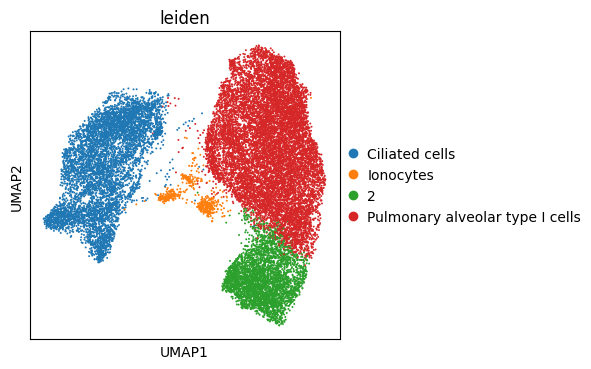

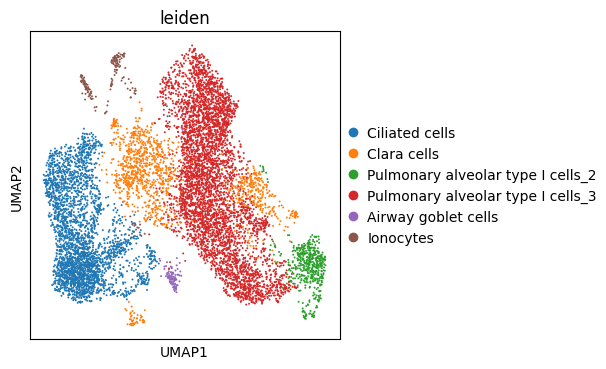

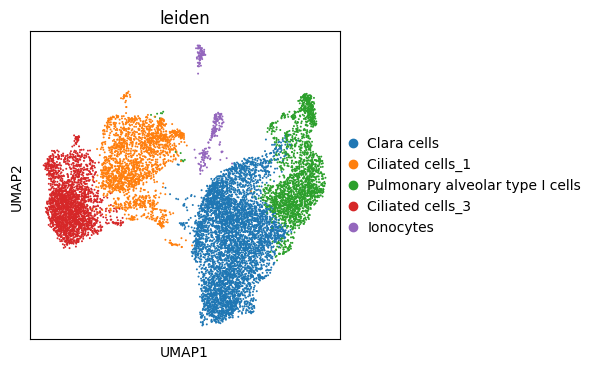

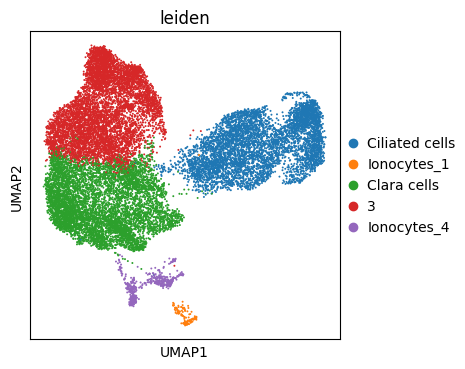

In [ ]:
# visualize clustering of each group with cell type annotations
sc.pl.umap(mock_adata, color=['leiden'], size=8)
sc.pl.umap(dpi1_adata, color=['leiden'], size=8)
sc.pl.umap(dpi2_adata, color=['leiden'], size=8)
sc.pl.umap(dpi3_adata, color=['leiden'], size=8)

In [ ]:
# Visualization of marker gene levels
available_genes = set(mock_adata.var_names)

# Subset marker genes for basal cells, ciliated cells, neuroendocrine cells, ionocytes, tuft cells, and goblet cells
epit_markers = markers[markers['source'].isin(['Airway epithelial cells'])]['target']
epit_markers = epit_markers[epit_markers.isin(available_genes)]

goblet_markers = markers[markers['source'].isin(['Airway goblet cells'])]['target']
goblet_markers = goblet_markers[goblet_markers.isin(available_genes)]

ciliated_markers = markers[markers['source'].isin(['Ciliated cells'])]['target']
ciliated_markers = ciliated_markers[ciliated_markers.isin(available_genes)]

club_markers = markers[markers['source'].isin(['Clara cells'])]['target']
club_markers = club_markers[club_markers.isin(available_genes)]

ionocyte_markers = markers[markers['source'].isin(['Ionocytes'])]['target']
ionocyte_markers = ionocyte_markers[ionocyte_markers.isin(available_genes)]

type1_markers = markers[markers['source'].isin(['Pulmonary alveolar type I cells'])]['target']
type1_markers = type1_markers[type1_markers.isin(available_genes)]

# create dictionary of marker genes
marker_genes = {
    'Epithelial': epit_markers.head().tolist(),
    'Ciliated': ciliated_markers.head().tolist(),
    'Club (Clara)': club_markers.head().tolist(),
    'Ionocyte': ionocyte_markers.head().tolist(),
    'Alveolar': type1_markers.head().tolist(),
    'Goblet': goblet_markers.head().tolist()
}

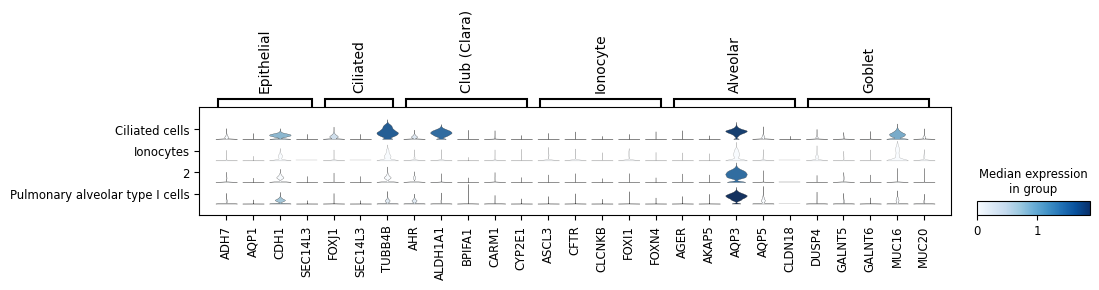

In [ ]:
# visualize marker gene levels in a stacked violin plot
sc.pl.stacked_violin(mock_adata, marker_genes, groupby='leiden')

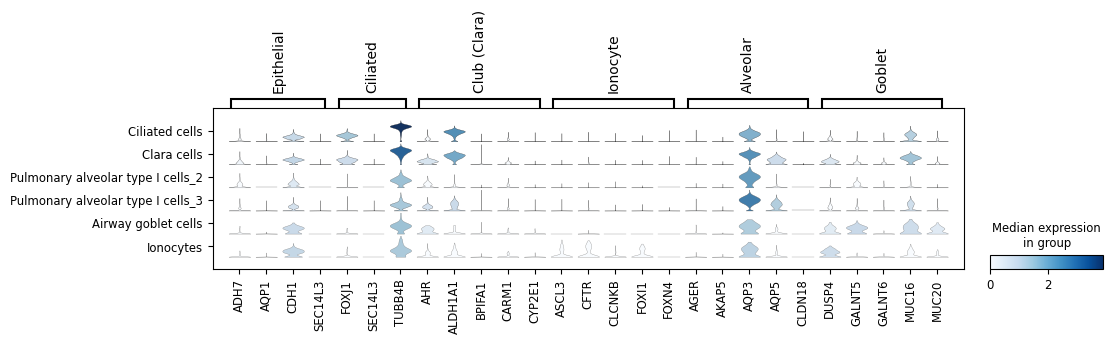

In [ ]:
available_genes = set(dpi1_adata.var_names)

sc.pl.stacked_violin(dpi1_adata, marker_genes, groupby='leiden')

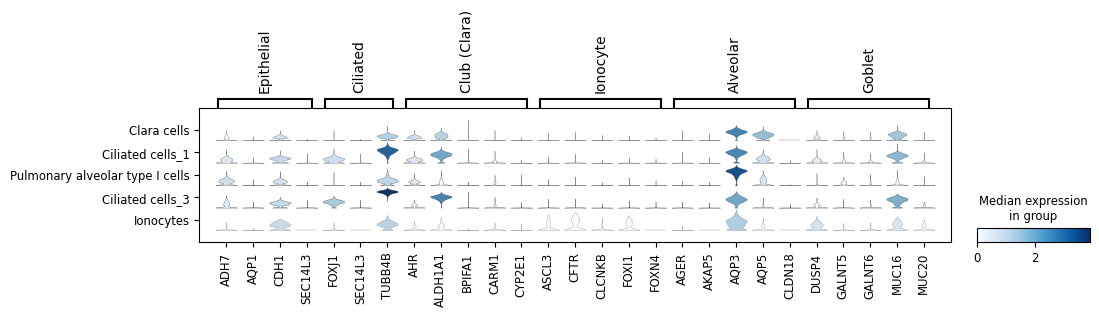

In [ ]:
available_genes = set(dpi2_adata.var_names)

sc.pl.stacked_violin(dpi2_adata, marker_genes, groupby='leiden')

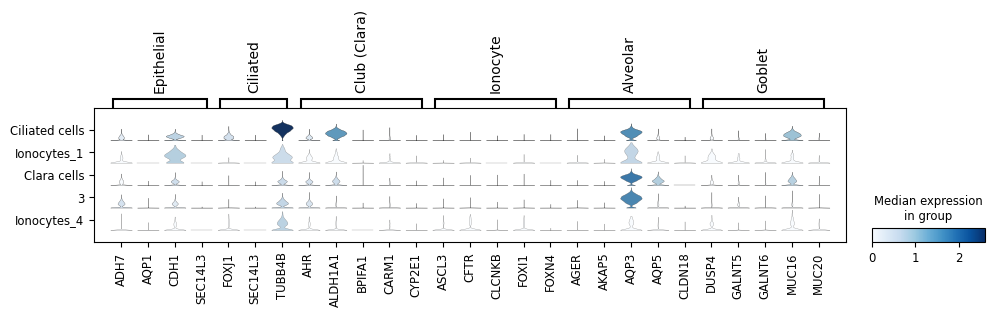

In [ ]:
available_genes = set(dpi3_adata.var_names)

sc.pl.stacked_violin(dpi3_adata, marker_genes, groupby='leiden')

### Expression levels for ACE2, ENO2, CTSL, TMPRSS2, and TMPRSS4

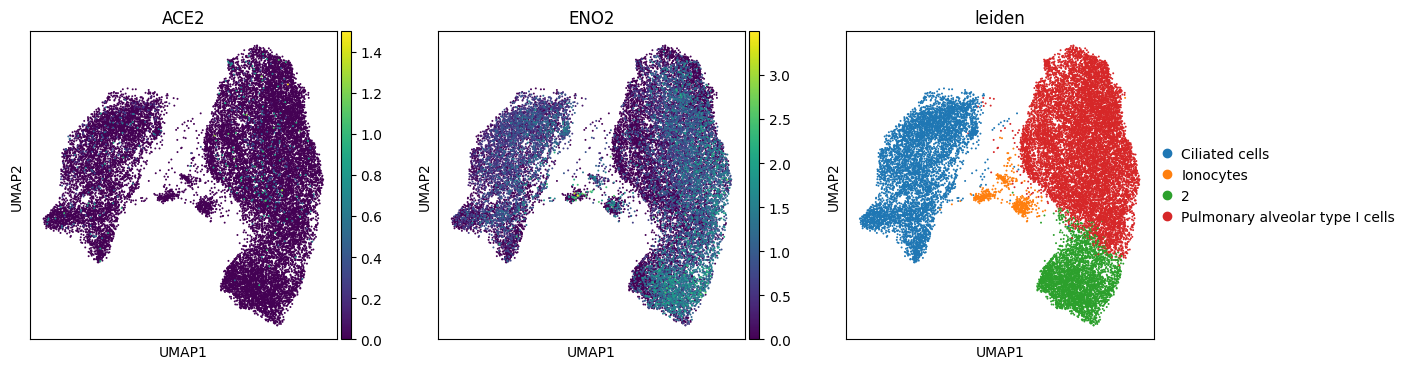

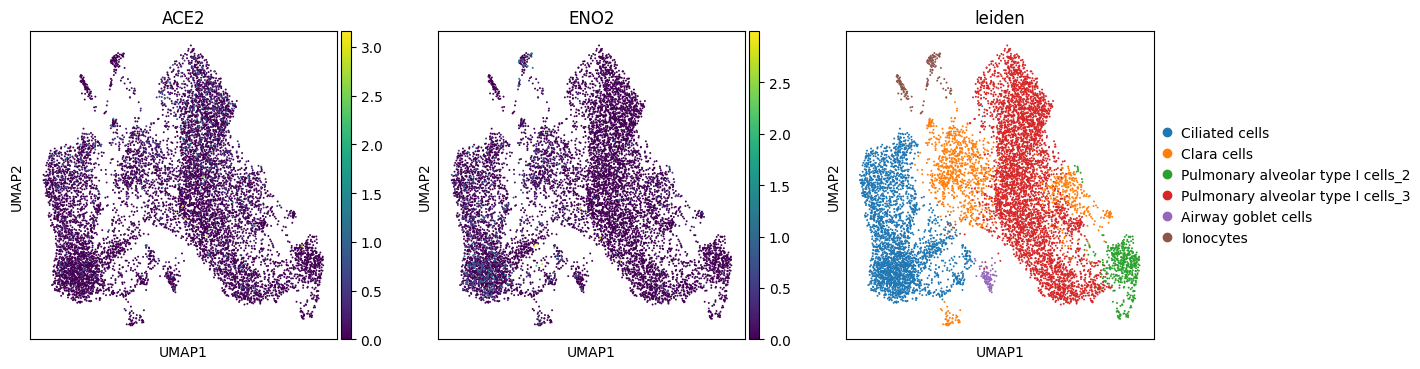

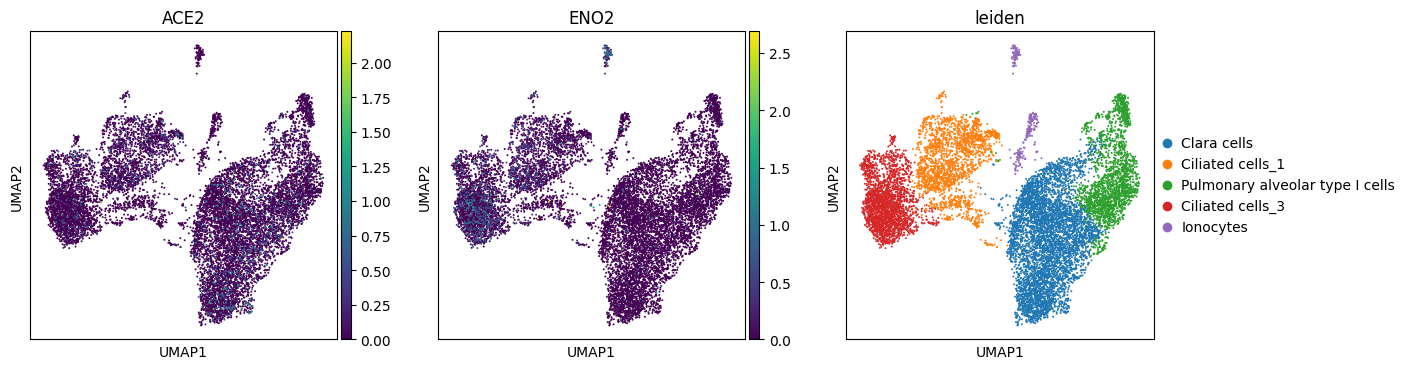

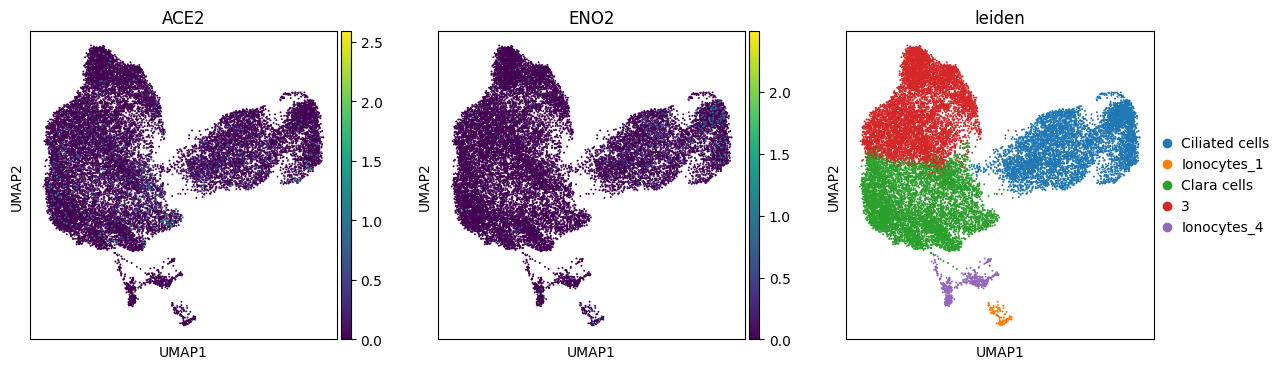

In [ ]:
# ACE2 and ENO2 expression levels
sc.pl.umap(mock_adata, color=['ACE2','ENO2','leiden'], size=8)
sc.pl.umap(dpi1_adata, color=['ACE2','ENO2','leiden'], size=8)
sc.pl.umap(dpi2_adata, color=['ACE2','ENO2','leiden'], size=8)
sc.pl.umap(dpi3_adata, color=['ACE2','ENO2','leiden'], size=8)

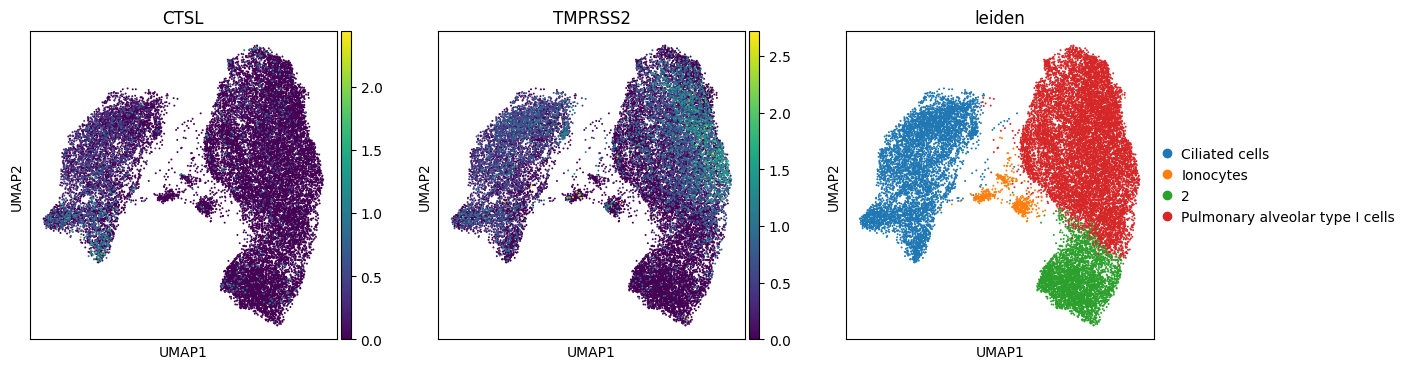

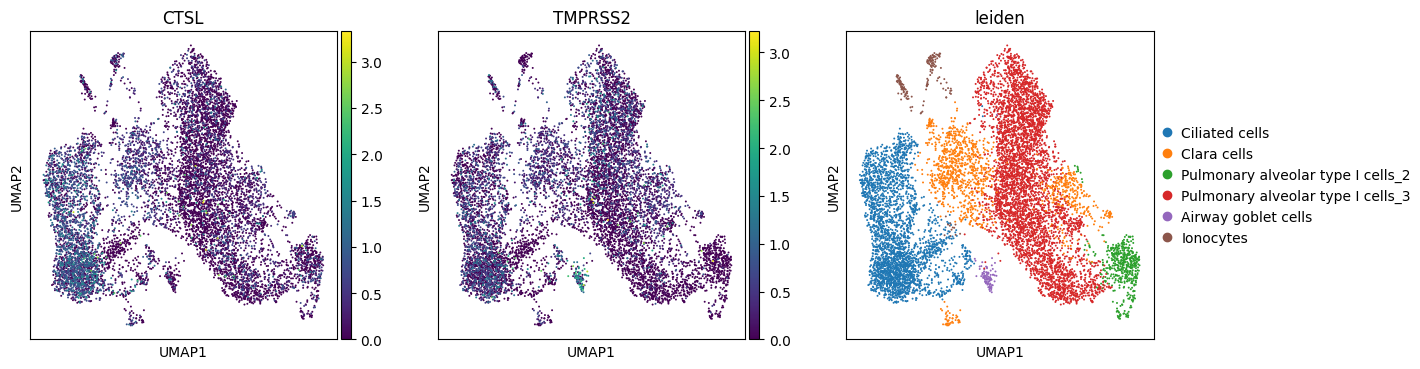

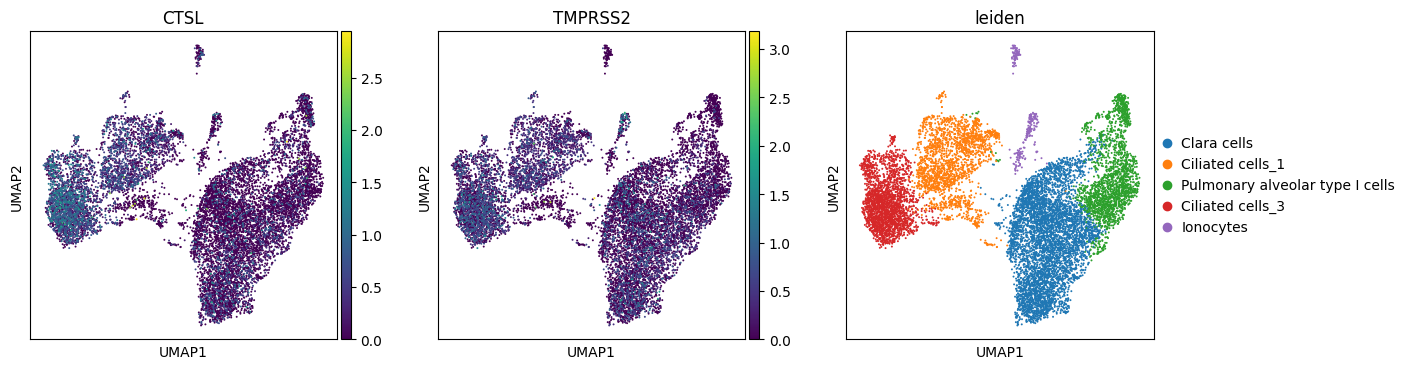

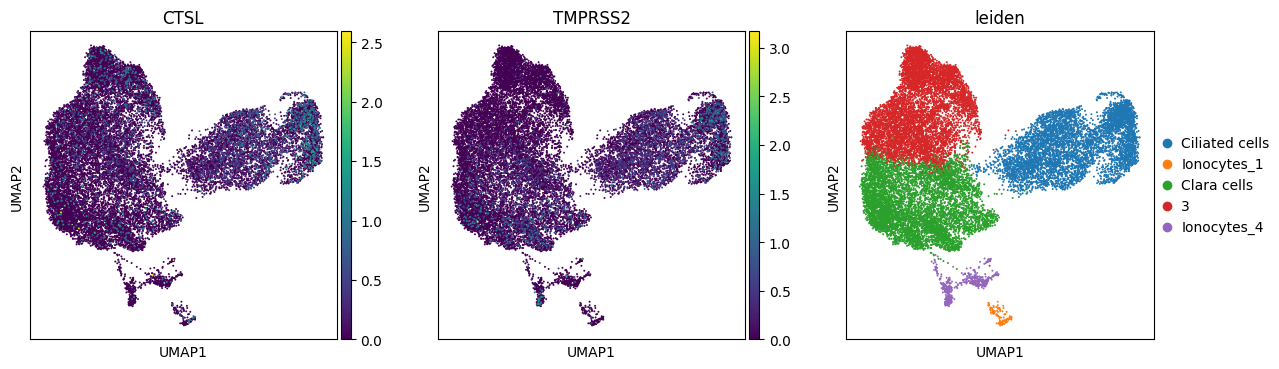

In [ ]:
# CTSL and TMPRSS2 expression levels
sc.pl.umap(mock_adata, color=['CTSL','TMPRSS2','leiden'], size=8)
sc.pl.umap(dpi1_adata, color=['CTSL','TMPRSS2','leiden'], size=8)
sc.pl.umap(dpi2_adata, color=['CTSL','TMPRSS2','leiden'], size=8)
sc.pl.umap(dpi3_adata, color=['CTSL','TMPRSS2','leiden'], size=8)

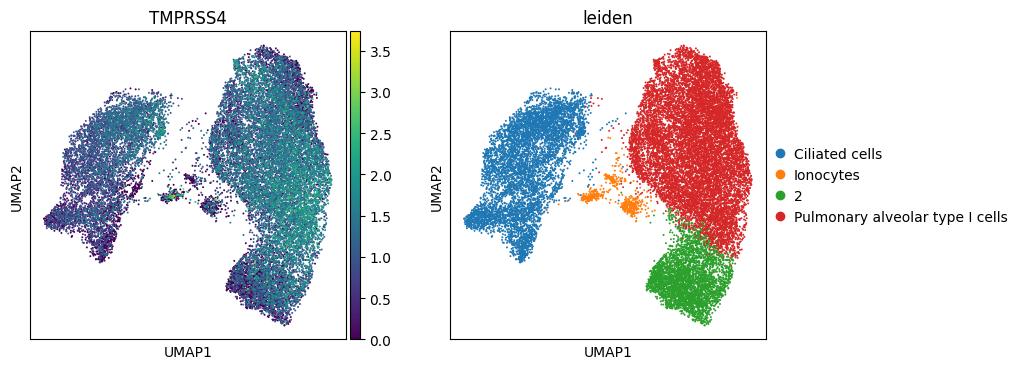

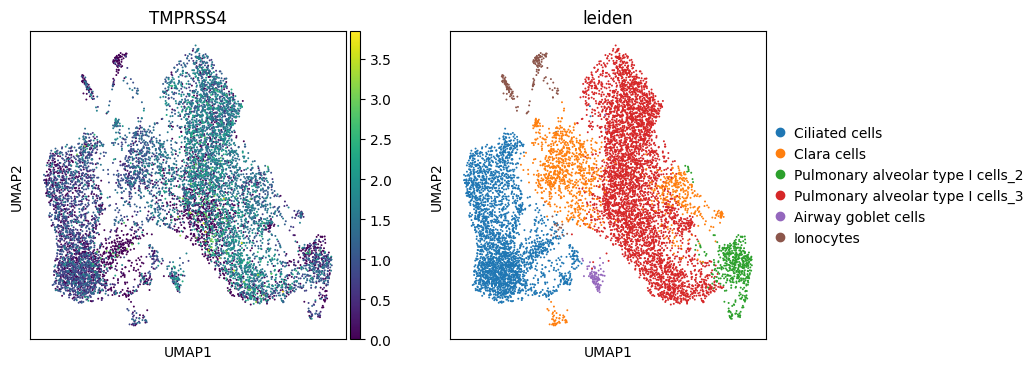

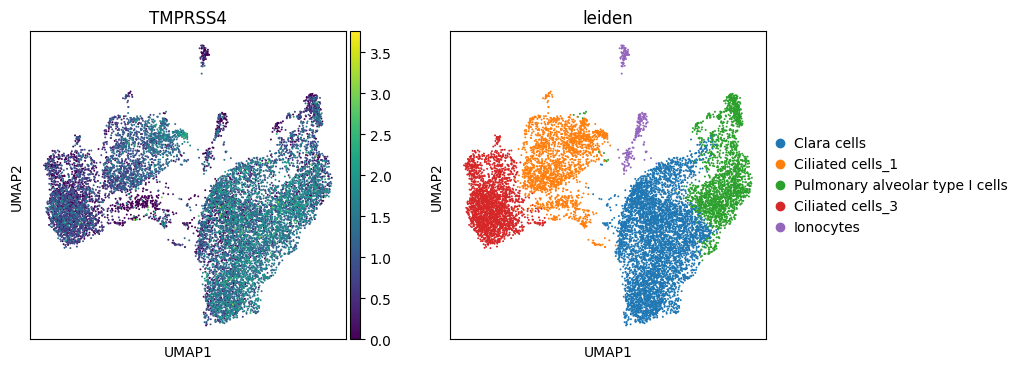

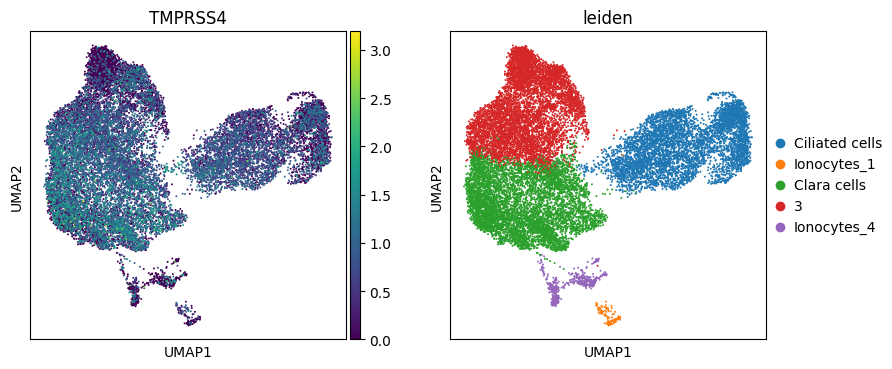

In [ ]:
# TMPRSS4 levels
sc.pl.umap(mock_adata, color=['TMPRSS4','leiden'], size=8)
sc.pl.umap(dpi1_adata, color=['TMPRSS4','leiden'], size=8)
sc.pl.umap(dpi2_adata, color=['TMPRSS4','leiden'], size=8)
sc.pl.umap(dpi3_adata, color=['TMPRSS4','leiden'], size=8)

## 5. Trajectory Analysis
For tracking cell differentiation throughout the infection. Club cells (Clara cells) are known to differentiate into ciliated cells, goblet cells, and pulmonary alveolar cells to repair the airways in case of damage (which can occur due to SARS-CoV-2 infection).

In [ ]:
# import the pyplot functionality from matplotlib
import matplotlib.pyplot as plt

In [ ]:
# function for graph construction and abstraction
def build_graph(adata):
  # build graph from expression data
  sc.tl.draw_graph(adata)

  # display the initial graph
  plt.rcParams['figure.figsize'] = (4,4)
  sc.pl.draw_graph(adata, color='leiden', size=10)

  # graph abstraction via PAGA
  sc.tl.paga(adata, groups='leiden')

  # display the graph after abstraction
  sc.pl.paga(adata, color=['leiden'])

  # rebuild graph with abstraction
  sc.tl.draw_graph(adata, init_pos='paga')
  sc.pl.draw_graph(adata, color='leiden', legend_loc='on data', size=8)

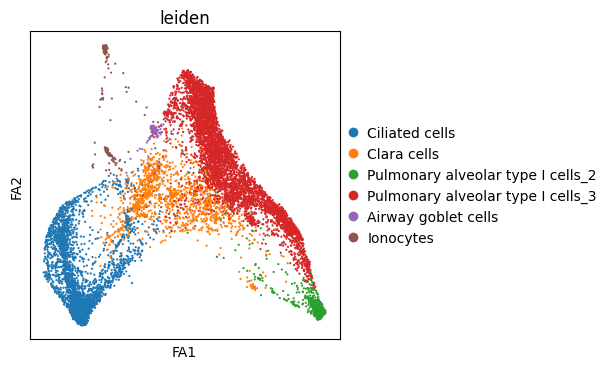

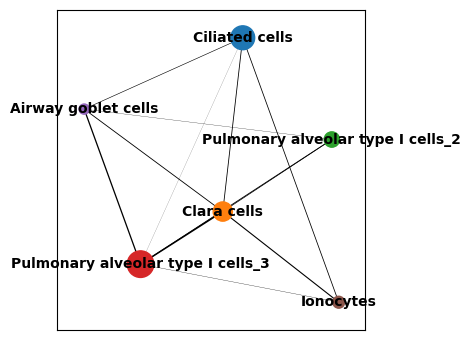

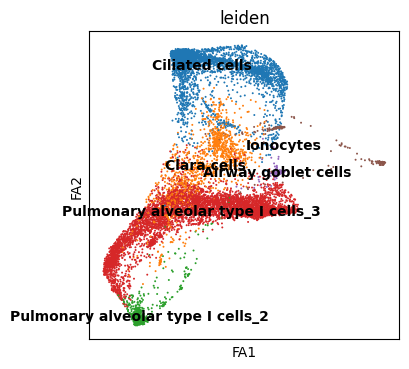

In [ ]:
# build graph for 1dpi
build_graph(dpi1_adata)

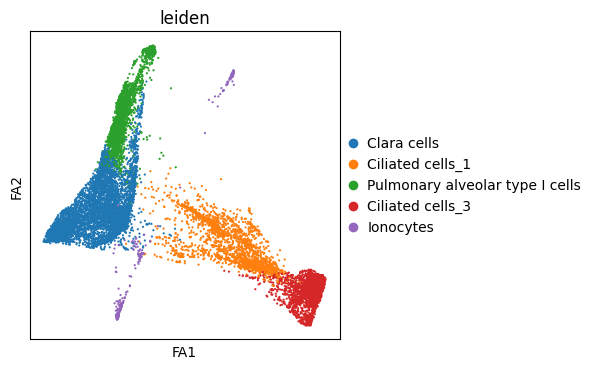

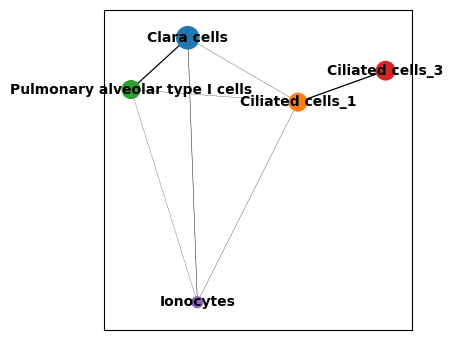

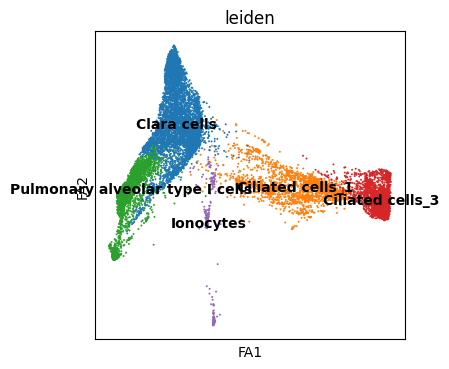

In [ ]:
# build graph for 2dpi
build_graph(dpi2_adata)

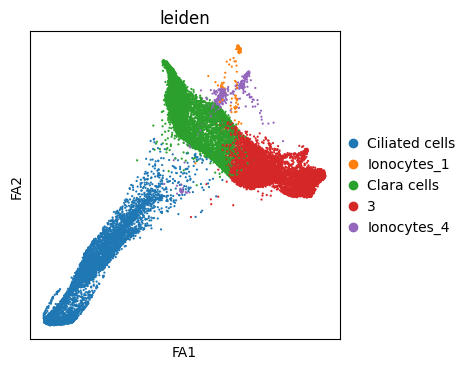

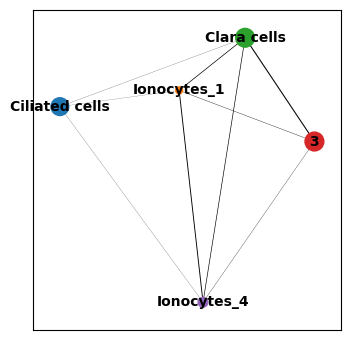

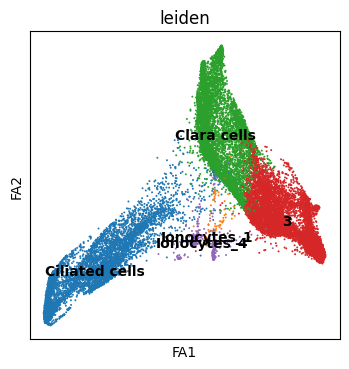

In [ ]:
# build graph for 3dpi
build_graph(dpi3_adata)

In [ ]:
# function for pseudotime analysis
def pseudotime_analysis(adata):
  # set Club (Clara) cells as the root cell
  adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden'] == 'Clara cells')[0]

  # perform pseudotime trajectory analysis
  sc.tl.dpt(adata)

  # display graph with trajectory inferred from pseudotime
  sc.pl.draw_graph(adata, color=['dpt_pseudotime', 'leiden'], legend_loc='on data', size=24)

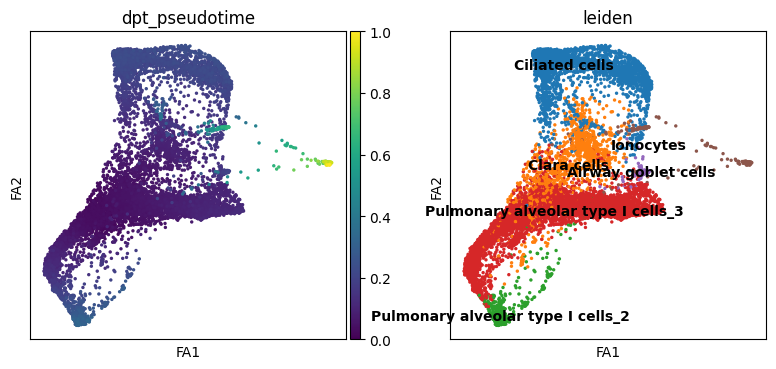

In [ ]:
# pseudotime analysis for 1dpi
pseudotime_analysis(dpi1_adata)

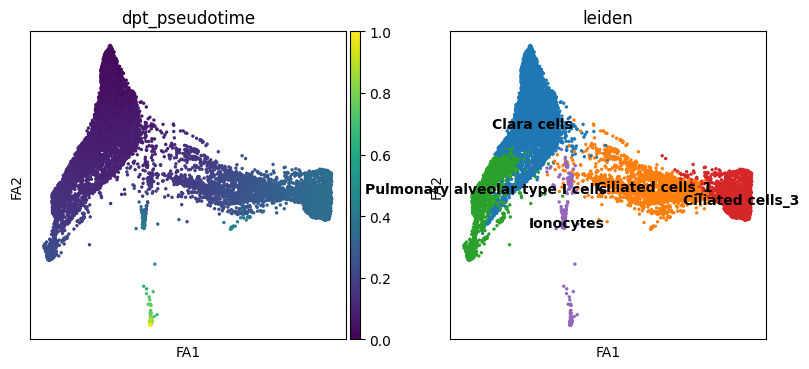

In [ ]:
# pseudotime analysis for 2dpi
pseudotime_analysis(dpi2_adata)

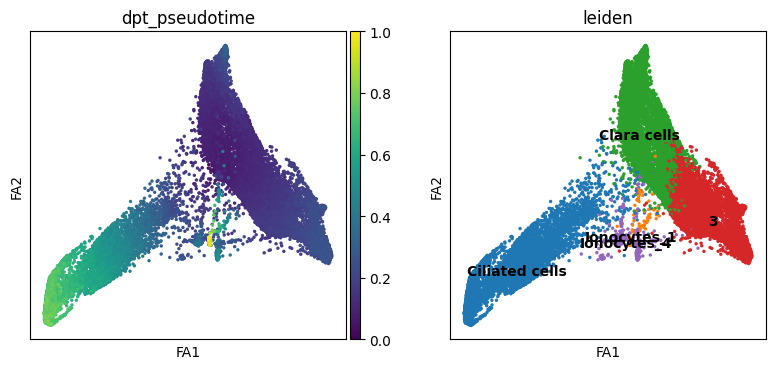

In [ ]:
# pseudotime analysis for 3dpi
pseudotime_analysis(dpi3_adata)